Initial analysis of results on 40 vs rest for different datasets

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

if "notebooks" in os.getcwd():
    os.chdir("..")
    home_dir = os.getcwd()

os.chdir(os.path.join(home_dir, "results"))

approx = pd.read_csv("approx_splits_test_results.csv")
exact = pd.read_csv("exact_splits_test_results.csv")
subset = pd.read_csv("subsplits_test_results.csv")

raw_results = pd.concat([approx, exact, subset], axis=0)

os.chdir(home_dir)
os.chdir("exact_weights")
weights = []
for f in os.listdir():
    with open(f, "rb") as fh:
        weights.append(pickle.load(fh)["weights"])

os.chdir(home_dir)
weights = np.stack(weights)

FileNotFoundError: [Errno 2] No such file or directory: 'exact_weights'

In [2]:
raw_results["kernel"] = [k.replace("EXACT_QUADRATIC", "Exact quad") for k in raw_results["kernel"].tolist()]

In [17]:
subset

,BSS00004,train,0.6719084098199175,Linear,promoters,0_to_40_fpath_/stg3/data1/sam/enhancer_prediction/fimo_scan/motif_count_matrices_pro_3
0,BSS00007,train,0.620390,Linear,promoters,0_to_40_fpath_/stg3/data1/sam/enhancer_predict...
1,BSS00043,train,0.419891,Linear,promoters,0_to_40_fpath_/stg3/data1/sam/enhancer_predict...
2,BSS00045,train,0.589799,Linear,promoters,0_to_40_fpath_/stg3/data1/sam/enhancer_predict...
3,BSS00062,train,0.595877,Linear,promoters,0_to_40_fpath_/stg3/data1/sam/enhancer_predict...
4,BSS00074,train,0.538510,Linear,promoters,0_to_40_fpath_/stg3/data1/sam/enhancer_predict...
...,...,...,...,...,...,...
1174,BSS01355,valid,0.807426,Poly,promoters,76_to_116_fpath_/stg3/data1/sam/enhancer_predi...
1175,BSS01360,valid,0.849481,Poly,promoters,76_to_116_fpath_/stg3/data1/sam/enhancer_predi...
1176,BSS01366,valid,0.769640,Poly,promoters,76_to_116_fpath_/stg3/data1/sam/enhancer_predi...
1177,BSS01377,valid,0.809393,Poly,promoters,76_to_116_fpath_/stg3/data1/sam/enhancer_predi...


In [4]:
raw_results["motif_set"] = [fpath.split("/")[-1].split("matrices_")[1] for fpath in raw_results["data_description"].tolist()]
raw_results["splits"] = [fpath.split("_fpath")[0] for fpath in raw_results["data_description"].tolist()]

unique_splits = raw_results["splits"].unique().tolist()
unique_split_dict = {k:i for i,k in enumerate(unique_splits)}
raw_results["split_number"] = [unique_split_dict[k] for k in raw_results["splits"].tolist()]

In [5]:
overview_only = raw_results[raw_results["cell_line"]=="ALL_LINES"].copy()
lines_only = raw_results[raw_results["cell_line"]!="ALL_LINES"].copy()
valid_only = lines_only[lines_only["train_or_test"]=="valid"].copy()
train_only = lines_only[lines_only["train_or_test"]=="train"].copy()

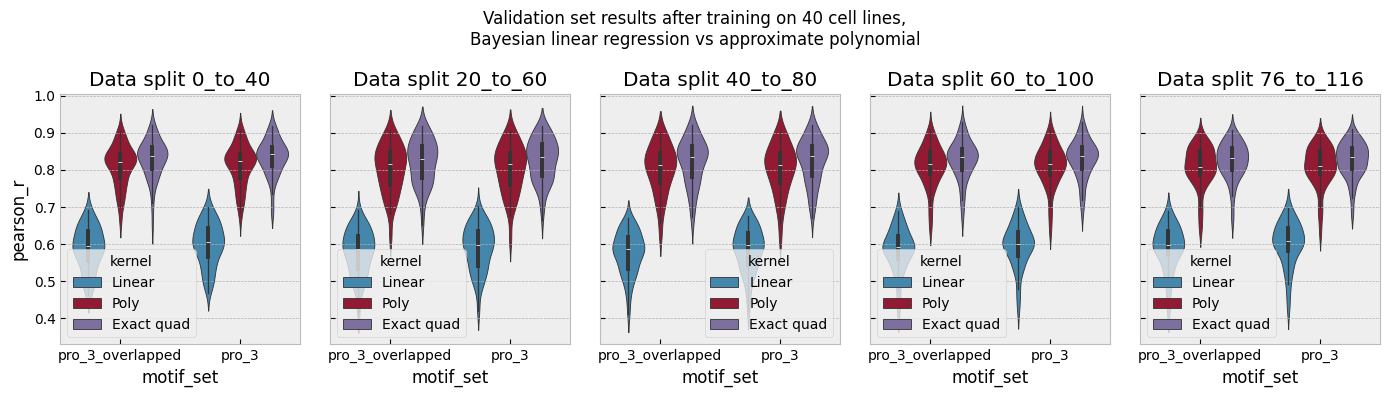

In [6]:
plt.style.use("bmh")

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(14,4), sharey=True)
axes = [ax1, ax2, ax3, ax4, ax5]

for i, ax in enumerate(axes):
    split = unique_splits[i]
    subset = valid_only[valid_only["splits"]==split]
    sns.violinplot(x="motif_set", y="pearson_r", hue="kernel", data=subset, ax=ax)
    ax.set_title(f"Data split {split}")

plt.suptitle("Validation set results after training on 40 cell lines,\nBayesian linear regression vs approximate polynomial")
plt.tight_layout()
plt.savefig("valid_set_results.png")

In [9]:
unique_lines = valid_only["cell_line"].unique()
datasets = valid_only["motif_set"].unique()

In [10]:
grouped_results = {"Kernel":[], "Dataset":[], "Train_or_test":[], "Median":[], "Mean":[]}

for split in unique_splits:
    data_split = lines_only[lines_only["splits"]==split]
    for group_type in ["train", "valid"]:
        group = data_split[data_split["train_or_test"]==group_type]
        for dataset in datasets:
            data_group = group[group["motif_set"]==dataset]
            for kernel in ["Linear", "Poly"]:
                kernel_group = data_group[data_group["kernel"]==kernel]
                grouped_results["Kernel"].append(kernel)
                grouped_results["Dataset"].append(dataset)
                grouped_results["Train_or_test"].append(group_type)
                grouped_results["Median"].append(np.median(kernel_group["pearson_r"].values))
                grouped_results["Mean"].append(np.mean(kernel_group["pearson_r"].values))

grouped_results = pd.DataFrame.from_dict(grouped_results)

In [11]:
grouped_results

,Kernel,Dataset,Train_or_test,Median,Mean
0,Linear,pro_3_overlapped,train,0.588401,0.579234
1,Poly,pro_3_overlapped,train,0.834729,0.828953
2,Linear,pro_3,train,0.598312,0.588946
3,Poly,pro_3,train,0.835411,0.828891
4,Linear,pro_3_overlapped,valid,0.593876,0.589559
5,Poly,pro_3_overlapped,valid,0.822386,0.811946
6,Linear,pro_3,valid,0.605783,0.599594
7,Poly,pro_3,valid,0.824093,0.812432
8,Linear,pro_3_overlapped,train,0.597292,0.597205
9,Poly,pro_3_overlapped,train,0.847298,0.845210


In [12]:
from scipy.stats import sem

for kernel in ["Linear", "Poly"]:
    for dataset in ["pro_3", "pro_3_overlapped"]:
        for tt in ["train", "valid"]:
            subset = grouped_results[grouped_results["Kernel"]==kernel]
            subset = subset[subset["Dataset"]==dataset]
            subset = subset[subset["Train_or_test"]==tt]
            print(f"{kernel}, {dataset}, {tt}")
            print(f"Mean: {np.mean(subset['Mean'].values)}, SEM: {sem(subset['Mean'].values)}\n")

Linear, pro_3, train
Mean: 0.5983798054106092, SEM: 0.005314492572571299

Linear, pro_3, valid
Mean: 0.5945861233771127, SEM: 0.0028446881221005156

Linear, pro_3_overlapped, train
Mean: 0.5882987575567444, SEM: 0.0052328526202892614

Linear, pro_3_overlapped, valid
Mean: 0.5847430364282069, SEM: 0.0027990548363367525

Poly, pro_3, train
Mean: 0.8359522771141503, SEM: 0.0037941210768028697

Poly, pro_3, valid
Mean: 0.807164241874271, SEM: 0.002104674215377303

Poly, pro_3_overlapped, train
Mean: 0.8360814160609724, SEM: 0.0037417172116467625

Poly, pro_3_overlapped, valid
Mean: 0.8072201905432514, SEM: 0.0019792634379123793



In [13]:
unique_splits

['0_to_40', '20_to_60', '40_to_80', '60_to_100', '76_to_116']

In [15]:
def plot_colcomp(x, col1, col2, dataset_list, kernel_type, axis, color="blue"):
    minval = np.min([x[:,col1].min(), x[:,col2].min()])
    maxval = np.max([x[:,col1].max(), x[:,col2].max()])
    eq_line = np.linspace(minval, maxval, 50)

    axis.scatter(x[:,col1], x[:,col2], color=color)
    axis.plot(eq_line, eq_line, linestyle="dashed", color="black")
    axis.set_xlabel(f"Pearson r for {dataset_list[col1]}")
    axis.set_ylabel(f"Pearson r for {dataset_list[col2]}")
    axis.set_title(f"{kernel_type} validation results for\n{dataset_list[col1]} vs {dataset_list[col2]}")

In [28]:
pearsonr_vals = []
from scipy.stats import pearsonr
for i in range(weights.shape[0]):
    for j in range(i+1,weights.shape[0]):
        print(pearsonr(weights[i,:-1], weights[j,:-1]))
        pearsonr_vals.append(pearsonr(weights[i,:-1], weights[j,:-1])[0] )

PearsonRResult(statistic=0.8033355543043619, pvalue=0.0)
PearsonRResult(statistic=0.64932416080204, pvalue=0.0)
PearsonRResult(statistic=0.5796132543953274, pvalue=0.0)
PearsonRResult(statistic=0.588160971834409, pvalue=0.0)
PearsonRResult(statistic=0.7854878535223717, pvalue=0.0)
PearsonRResult(statistic=0.5840051747287187, pvalue=0.0)
PearsonRResult(statistic=0.5922489775966202, pvalue=0.0)
PearsonRResult(statistic=0.6976115315134093, pvalue=0.0)
PearsonRResult(statistic=0.5842140579948083, pvalue=0.0)
PearsonRResult(statistic=0.7329670672822818, pvalue=0.0)


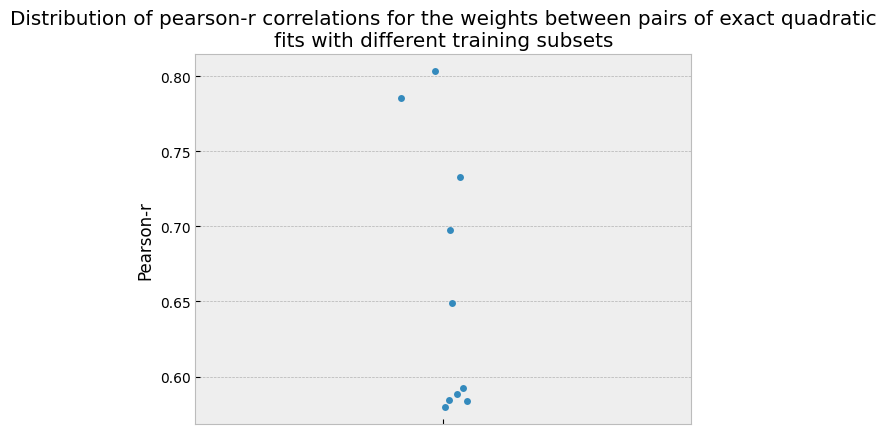

In [35]:
sns.stripplot(pearsonr_vals)
plt.ylabel("Pearson-r")
plt.title("Distribution of pearson-r correlations for the weights between pairs of exact quadratic\nfits with different training subsets")
plt.savefig("exact_quad_ correlations")

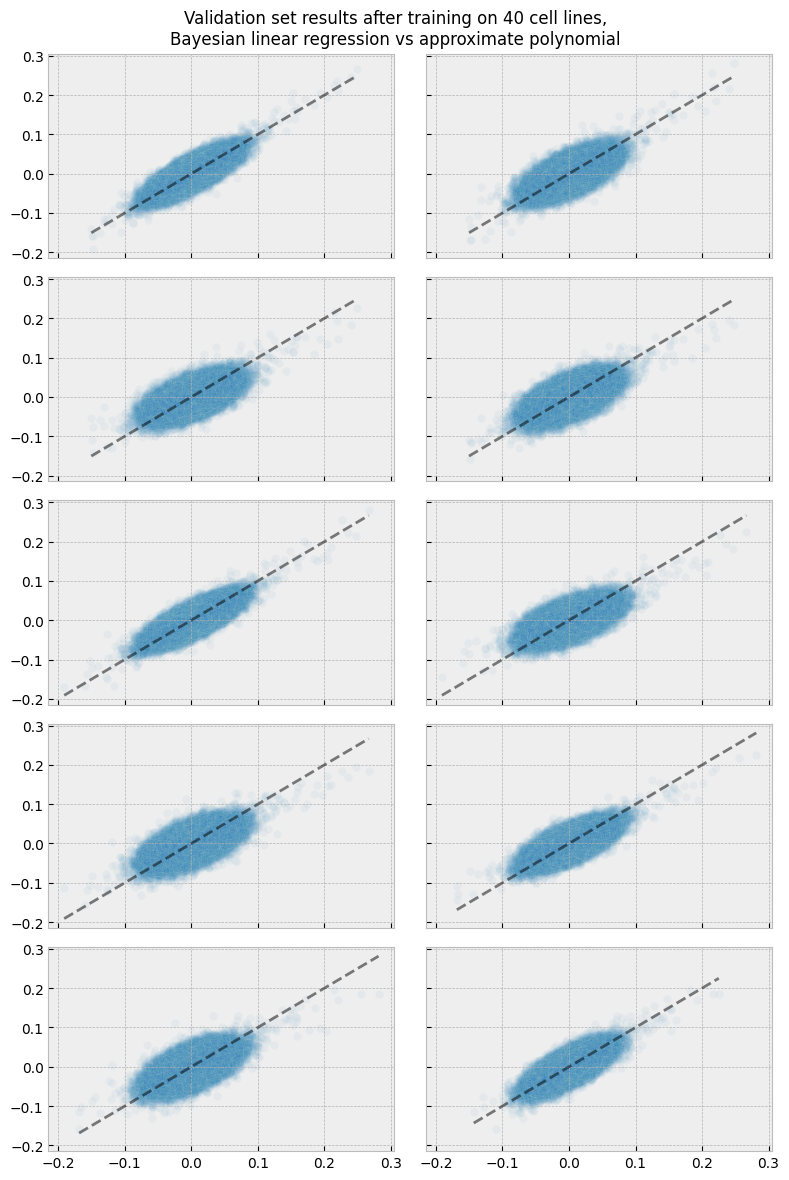

In [26]:
plt.style.use("bmh")

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2, figsize=(8,12), sharey=True, sharex=True)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

counter1, counter2 = 0, 1

for i, ax in enumerate(axes):
    sns.scatterplot(x=weights[counter1,:-1], y=weights[counter2,:-1], alpha=0.05, ax=ax)
    xall = np.linspace(weights[counter1,:-1].min(), weights[counter1,:-1].max(), 100)
    ax.plot(xall, xall, linestyle="dashed", alpha=0.5, color="black")
    #ax.set_title(f"Data split {split}")
    counter2 += 1
    if counter2 >= 5:
        counter1 += 1
        counter2 = counter1 + 1

plt.suptitle("Validation set results after training on 40 cell lines,\nBayesian linear regression vs approximate polynomial")
plt.tight_layout()
plt.savefig("valid_set_results.png")

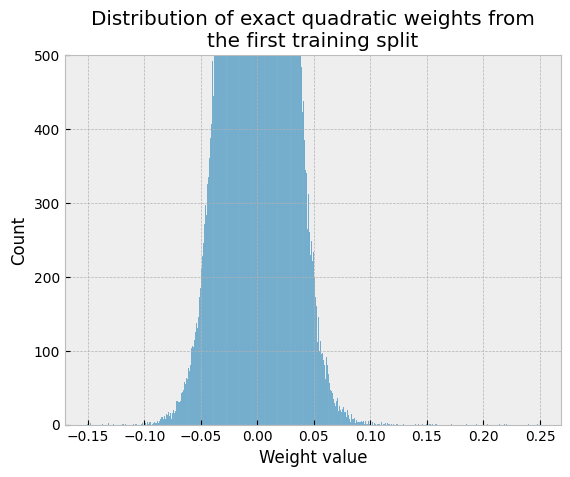

In [41]:
from scipy.stats import shapiro
sns.histplot(weights[0,:-1])
plt.title("Distribution of exact quadratic weights from\nthe first training split")
plt.xlabel("Weight value")
plt.savefig("example_Weight_distro.png")
plt.ylim(0,500)
plt.show()